In [7]:
import os
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [8]:
# You first need to set you directory structure
# and collect the behavioral files for the localizer and the
# study task separately.  Given that each task will be modeled
# separately treat them separately.
proj_dir = '/home/nmatt015/Mattfeld_PSB6351/behav'
# use os.path.join or Pathlib to define location of files
# use glob and sort to grab relevant files...I would separately handle localizer and task .tsv files

loc_behav_files = sorted(glob(proj_dir + '/*task-loc*.tsv'))
study_behav_files = sorted(glob(proj_dir + '/*task-study*.tsv'))

In [3]:
loc_behav_files[0]

'/home/nmatt015/Mattfeld_PSB6351/behav/sub-021_task-loc_run-1_events.tsv'

In [4]:
study_behav_files[0]

'/home/nmatt015/Mattfeld_PSB6351/behav/sub-021_task-study_run-1_events.tsv'

In [5]:
# Making seperate directories for each run of the localizer task 
loc_behav_files_dict = {}

# Making sure it runs here before trying it in next cell
for idx, curr_behav_file in enumerate(loc_behav_files):
    loc_behav_files_dict[f'run{idx + 1}'] = []  # Initialize each run with an empty list
print(loc_behav_files_dict)

{'run1': [], 'run2': []}


In [3]:
# set up dictionaries to hold onset times for each condition across runs
loc_behav_files_dict = {'run1': [], 'run2': []}  # onset times
loc_face_onset_times = {'run1': [], 'run2': []}  # face onset times
loc_scene_onset_times = {'run1': [], 'run2': []}  # scene onset times

# In this cell I'm going to first work on the localizer task

# Define variables that can distinguish between runs and have 
# onset times and their duration embedded.  I used dictionaries
# This will need to be accomplished for each type of stimulus or
# or regressor you want to isolate onset times for

# Iterate over your text files for the localizer task.
# The variable curr_behav_file will be a string variable with
# the full path to the separate runs of the localizer task. idx is a counter
# used for indexing.

for idx, curr_behav_file in enumerate(loc_behav_files):
    # Read the current behavioral file
    curr_behav_data = pd.read_csv(curr_behav_file, sep='\t')

     # This is where I defined the keys in my dictionaries that were created above
    # and defined the output associated with each key as an empty list
    # example --> name_of_dictionary_defined_above[f'run{SOMETHING}'] = []
    
    # I'm using the pandas function read_csv to read in the log files
    # Temporary lists to store onset times for each trial type in the current run
    tmp_face_onset = []
    tmp_scene_onset = []

    # Given that the localizer task is a block design you don't need 
    # the onset time of each stimulus.  You just need the first and then
    # the total duration of all stimuli to create your blocked time
    # to convolve with your hemodynamic response.  I used temporary lists
    # to grab all onset times and then picked the first...you can choose
    # another way.
    
    # iterating over ????? here...i is counter for indexing
    # What column header would you want to iterate over?  Why?
    
    # Iterate through trial types and collect onsets for face and scene blocks
    for i, curr_trial_type in enumerate(curr_behav_data['trial_type']):
        if curr_trial_type == 'face':
            tmp_face_onset.append(curr_behav_data['onset'][i])
        elif curr_trial_type == 'scene':
            tmp_scene_onset.append(curr_behav_data['onset'][i])
        elif curr_trial_type == 'math' and len(tmp_face_onset) > 0:
            # Add the first onset and block duration for faces when a math block starts
            loc_face_onset_times[f'run{idx + 1}'].append(f"{tmp_face_onset[0]}:25")
            tmp_face_onset = []  # reset list for the next face block
        elif curr_trial_type == 'math' and len(tmp_scene_onset) > 0:
            # Add the first onset and block duration for scenes when a math block starts
            loc_scene_onset_times[f'run{idx + 1}'].append(f"{tmp_scene_onset[0]}:25")
            tmp_scene_onset = []  # reset the list for the next scene block

  # Here I am appending the onset of the stimulus if the current
            # trial type is a scene.
            # I used a list append function here to grow my temporary list variable
            # reference above face-by-face...you can choose a different way
            
        # here I am using the first trial type when it becomes math and the 
        # face onset list variable is ???? elements long (just exited a face block)
        # to assign the first element of the tmp_face_onset list variable to the 
        # dictionary that I created earlier.
        # the format of AFNI stimulus timing files is the following:
        #
        # onset_time:duration (e.g., 6.3:25, 12.7:25, 22.5:25) --> A block started at 6.3, 12.7, and 22.5 seconds
        # into the experiment and each block lasted for 25 seconds in length...make sure these numbers match your
        # experimental design

# The following code creates a string element that has the square brackets
# removed.  This is important for the following steps below.
# I'm leaving this for you...If you opt to not use dictionaries like I did then
# you'll have to find a different way.

# convert onset time lists to AFNI format for each run
loc_scene_run1_data = ", ".join(loc_scene_onset_times['run1'])
loc_scene_run2_data = ", ".join(loc_scene_onset_times['run2'])
loc_face_run1_data = ", ".join(loc_face_onset_times['run1'])
loc_face_run2_data = ", ".join(loc_face_onset_times['run2'])

# Here I am defining the sink directory where I would like to save the timing files
# HINT you shouldn't save these text files in teh same directory where your code resides
# you can also you Pathlib to create this and make the direcotry if it doesn't exist
# set up directory to save AFNI timing files
evs_sink_dir = os.path.join(proj_dir, 'evs')
if not os.path.isdir(evs_sink_dir):
    os.makedirs(evs_sink_dir)

# below I am defining the file names for the localizer (loc) face and scene evs.
# each run is captured on a separate line with the multiple onsets within a run
# captured on a single line
# I'm leaving this for you...again this may constrain the way you do things above
# but it gives you a hint of how to output data into a AFNI style format
# your output should eventually look like the following:
#
# 6.3:25, 30.7:25, 76.5:25, 137.3:25, 225.1:25
# 6.3:25, 30.7:25, 76.5:25, 137.3:25, 225.1:25
#
# The first line refers to run1 and the second line refers to run2
# in this case the onset times were identical for this particular condition across runs

# save timing files for face and scene conditions in AFNI format
loc_scene_evs_file = 'loc_scene_evs.1D'
with open(os.path.join(evs_sink_dir, loc_scene_evs_file), 'wt') as fp:
    fp.writelines([f'{loc_scene_run1_data}\n', f'{loc_scene_run2_data}\n'])

loc_face_evs_file = 'loc_face_evs.1D'
with open(os.path.join(evs_sink_dir, loc_face_evs_file), 'wt') as fp:
    fp.writelines([f'{loc_face_run1_data}\n', f'{loc_face_run2_data}\n'])

In [26]:
ls /home/nmatt015/Mattfeld_PSB6351/behav/loc_behav_files_dict/loc_face_evs.1D

loc_face_evs.1D  loc_scene_evs.1D


In [4]:
loc_face = '/home/nmatt015/Mattfeld_PSB6351/behav/loc_behav_files_dict/loc_face_evs.1D'

with open(loc_face, 'r') as file:
    loc_face_contents = file.read()
    print(loc_face_contents)

6.01005580311:25, 81.0102012303:25, 156.010947896:25, 231.012253435:25, 306.02929695:25, 381.030623221:25, 456.031369286:25, 6.01005580311:25, 81.0102012303:25, 156.010947896:25, 231.012253435:25, 306.02929695:25, 381.030623221:25, 456.031369286:25, 6.01005580311:25, 81.0102012303:25, 156.010947896:25, 231.012253435:25, 306.02929695:25, 381.030623221:25, 456.031369286:25
6.010115296:25, 81.0108769855:25, 156.012685209:25, 231.012760026:25, 306.014053246:25, 381.014985602:25, 456.015892418:25, 6.010115296:25, 81.0108769855:25, 156.012685209:25, 231.012760026:25, 306.014053246:25, 381.014985602:25, 456.015892418:25, 6.010115296:25, 81.0108769855:25, 156.012685209:25, 231.012760026:25, 306.014053246:25, 381.014985602:25, 456.015892418:25



In [5]:
loc_scene = '/home/nmatt015/Mattfeld_PSB6351/behav/loc_behav_files_dict/loc_scene_evs.1D'

with open(loc_scene, 'r') as file:
    loc_scene_contents = file.read()
    print(loc_scene_contents)

43.5105377558:25, 118.509990601:25, 193.51066846:25, 268.528655448:25, 343.529607034:25, 418.530665587:25, 493.531335934:25, 43.5105377558:25, 118.509990601:25, 193.51066846:25, 268.528655448:25, 343.529607034:25, 418.530665587:25, 493.531335934:25, 43.5105377558:25, 118.509990601:25, 193.51066846:25, 268.528655448:25, 343.529607034:25, 418.530665587:25, 493.531335934:25
43.5103616808:25, 118.510910338:25, 193.512537979:25, 268.513247087:25, 343.514315555:25, 418.515630709:25, 493.516578389:25, 43.5103616808:25, 118.510910338:25, 193.512537979:25, 268.513247087:25, 343.514315555:25, 418.515630709:25, 493.516578389:25, 43.5103616808:25, 118.510910338:25, 193.512537979:25, 268.513247087:25, 343.514315555:25, 418.515630709:25, 493.516578389:25



In [7]:
# Making seperate directories for each run of the study task 
study_behav_files_dict = {}

# Making sure it runs here before trying it later
for idx, curr_behav_file in enumerate(study_behav_files):
    study_behav_files_dict[f'run{idx + 1}'] = []  
    
print(study_behav_files_dict) 

{'run1': [], 'run2': [], 'run3': [], 'run4': []}


In [4]:
# Similar to above I am creating empty dictionary variables
# for each of the events that I am interested in.
# I will then insert run keys to separate the timing files 
# for the events of interest and their specific runs.

# Here I am iterating over the study behavior files.  There should be
# 4 of them.

# set up dictionaries for each condition with run keys for each run
# Never thought of shortening variable names like with b4, thanks Aaron. 
fix_b4_c_cond = {'run1': [], 'run2': [], 'run3': [], 'run4': []}
fix_b4_ic_cond = {'run1': [], 'run2': [], 'run3': [], 'run4': []}
events_remain = {'run1': [], 'run2': [], 'run3': [], 'run4': []}
facefix_b4_bl = {'run1': [], 'run2': [], 'run3': [], 'run4': []}
scenefix_b4_bl = {'run1': [], 'run2': [], 'run3': [], 'run4': []}  

# Iterate over the study behavior files 
for idx, curr_behav_file in enumerate(study_behav_files):
    curr_behav_data = pd.read_csv(curr_behav_file, sep='\t')

    # I set the run key for each condition of interest
    # Again if you opt not to use the dictionaries as I did
    # you'll need to utilize a different way. HINT you should
    # update the key for as many events of interest you are
    # attempting to isolate
    
    # I read in the current study run behavioral file
    # NOTE: sometimes it is not good practice to use the same
    # variable names across cells. It may execute but erroneously
    
    # I iterate now over the contents of the run specific data.
    # Again...you'll want to isolate the column header that lets
    # you assess the event or trial types of interest
    for i, curr_trial_type in enumerate(curr_behav_data['trial_type']):
        if 'face' in curr_trial_type:
            tmp_fix_onset = curr_behav_data['onset'][i]
            facefix_b4_bl[f'run{idx+1}'].append(tmp_fix_onset)

        elif 'scene' in curr_trial_type:
            tmp_fix_onset = curr_behav_data['onset'][i]
            scenefix_b4_bl[f'run{idx+1}'].append(tmp_fix_onset)

        elif curr_trial_type == 'COND' and tmp_fix_onset is not None:
            if curr_behav_data['acc'][i] == 1.0:  # Correct response
                fix_b4_c_cond[f'run{idx+1}'].append(tmp_fix_onset)
            elif curr_behav_data['acc'][i] == 0.0:  # Incorrect response
                fix_b4_ic_cond[f'run{idx+1}'].append(tmp_fix_onset)
            tmp_fix_onset = None

        elif curr_trial_type == 'baseline' and i > 0 and 'face' in curr_behav_data['trial_type'][i-1]:
            events_remain[f'run{idx+1}'].append(tmp_fix_onset)

stimulus_condition_dicts = [fix_b4_c_cond, fix_b4_ic_cond, events_remain, facefix_b4_bl, scenefix_b4_bl]

# Given that we're setting things up to analyze in AFNI
# you can't have runs that don't have any events in them....or
# you can but you can't have an empty row...thus here I am checking
# to see if the runs are empty and if they are adding a filler (-1)

for stimulus_dict in stimulus_condition_dicts:
    for curr_run in ['run1', 'run2', 'run3', 'run4']:
        if len(stimulus_dict[curr_run]) == 0:
            stimulus_dict[curr_run].append(-1)
        # the code above would have to be repeated for each variable that is 
        # capturing a stimulus condition of interest. THis is not the most
        # effecient way of coding and can be improved upon.

# Reformatting as before to save as a text file with no square brackets
# use what you did for the localizer task here. If you use the same way as before
# or that I used you'll have to have a separate line for each run of each condition
# This is not a great way to code and could be improved upon

# Creating and checking to see if the directory exists for where you want to save your text files
# use the way you did this for the localizer task

# Format each dictionary into comma-separated strings for each run
def format_onset_times(data_dict, run_keys):
    return [", ".join(map(str, data_dict[run])) for run in run_keys]

run_keys = ['run1', 'run2', 'run3', 'run4']
fix_b4_c_cond_data = format_onset_times(fix_b4_c_cond, run_keys)
fix_b4_ic_cond_data = format_onset_times(fix_b4_ic_cond, run_keys)
events_remain_data = format_onset_times(events_remain, run_keys)
facefix_b4_bl_data = format_onset_times(facefix_b4_bl, run_keys)
scenefix_b4_bl_data = format_onset_times(scenefix_b4_bl, run_keys)

# Directory for saving the output files
evs_sink_dir = os.path.join(proj_dir, 'event_related_output')
if not os.path.exists(evs_sink_dir):
    os.makedirs(evs_sink_dir)

# Save each condition's timing data
with open(os.path.join(evs_sink_dir, 'fix_b4_c_cond_evs.1D'), 'wt') as fp:
    fp.writelines([f'{fix_b4_c_cond_data[0]}\n', f'{fix_b4_c_cond_data[1]}\n', f'{fix_b4_c_cond_data[2]}\n', f'{fix_b4_c_cond_data[3]}\n'])

with open(os.path.join(evs_sink_dir, 'fix_b4_ic_cond_evs.1D'), 'wt') as fp:
    fp.writelines([f'{fix_b4_ic_cond_data[0]}\n', f'{fix_b4_ic_cond_data[1]}\n', f'{fix_b4_ic_cond_data[2]}\n', f'{fix_b4_ic_cond_data[3]}\n'])

with open(os.path.join(evs_sink_dir, 'events_remain_evs.1D'), 'wt') as fp:
    fp.writelines([f'{events_remain_data[0]}\n', f'{events_remain_data[1]}\n', f'{events_remain_data[2]}\n', f'{events_remain_data[3]}\n'])

with open(os.path.join(evs_sink_dir, 'facefix_b4_bl_evs.1D'), 'wt') as fp:
    fp.writelines([f'{facefix_b4_bl_data[0]}\n', f'{facefix_b4_bl_data[1]}\n', f'{facefix_b4_bl_data[2]}\n', f'{facefix_b4_bl_data[3]}\n'])

with open(os.path.join(evs_sink_dir, 'scenefix_b4_bl_evs.1D'), 'wt') as fp:
    fp.writelines([f'{scenefix_b4_bl_data[0]}\n', f'{scenefix_b4_bl_data[1]}\n', f'{scenefix_b4_bl_data[2]}\n', f'{scenefix_b4_bl_data[3]}\n'])

# creating my separate ev files with runs written to each line
# use the way you did this before. HINT if you keep the same way as before
# and how I did it you'll need a separate block of code for each regressor (aka stimulus condition)
# you are trying to model and a separate line within each block for each run
# In the end it should look something like the following in one file:
#
# 6.3, 30.7, 76.5, 137.3, 225.1
# 6.3, 30.7, 76.5, 137.3, 225.1
# 6.3, 30.7, 76.5, 137.3, 225.1
# 6.3, 30.7, 76.5, 137.3, 225.1
# 
# In the example above this stimulus had the exact same onset times across each runs
# your output should in format look like this but your onset times should not be the
# same across runs!!!!

In [5]:
ls /home/nmatt015/Mattfeld_PSB6351/event_related_output

events_remain_evs.1D  fix_b4_c_cond_evs.1D   scenefix_b4_bl_evs.1D
facefix_b4_bl_evs.1D  fix_b4_ic_cond_evs.1D


In [48]:
events_remain = '/home/nmatt015/Mattfeld_PSB6351/event_related_output/events_remain_evs.1D'

with open(events_remain, 'r') as file:
    events_remaint_contents = file.read()
    print(events_remaint_contents)

220.803968898, 249.804284991, 278.805800558, 307.805171075, 348.806782191, 357.308823879, 411.80766527, 426.307100989, 505.808090434, 576.809047729
50.8014040926, 124.303336711, 156.802903735, 220.804915376, 276.304482099, 284.80576991, 311.305068014, 319.806201384, 328.306319168, 354.805698098, 369.305902718, 377.807046905, 406.807541477, 439.306954961, 453.807147562, 470.808387899, 556.808770095, 577.30897802, 612.809495128
26.7925014903, 82.2933707478, 96.7934831233, 123.293844888, 152.295224342, 205.298016903, 213.798280415, 260.795873957, 333.296823439, 356.297240791, 414.298979306, 428.798221222, 467.298759363, 475.79988492, 484.300293558
6.30092604605, 77.3017222895, 106.302157068, 155.803979715, 188.303347828, 211.303604729, 219.805053291, 295.804823432, 356.306795111, 387.806176445, 426.306769271, 452.807132839, 467.307345571, 612.809493926



In [50]:
facefix_b4_bl = '/home/nmatt015/Mattfeld_PSB6351/event_related_output/facefix_b4_bl_evs.1D'

with open(facefix_b4_bl, 'r') as file:
    facefix_b4_bl_contents = file.read()
    print(facefix_b4_bl_contents)

14.803395903, 35.3014281302, 41.3013421959, 64.3027553027, 76.3018370687, 82.3019404301, 88.3019848996, 94.3025320541, 100.302211453, 135.305851638, 141.302782645, 184.806349515, 196.803559358, 220.803968898, 243.807542078, 249.804284991, 278.805800558, 295.806069178, 301.805061404, 307.805171075, 316.306363637, 322.305953497, 334.305529835, 348.806782191, 357.308823879, 365.807051411, 411.80766527, 426.307100989, 434.807999091, 440.807045102, 452.807174904, 467.308481344, 481.808714508, 487.807689908, 505.808090434, 526.30830557, 540.808519804, 546.808703091, 552.808791429, 558.808795335, 567.808939861, 570.809272179, 573.809119241, 576.809047729, 585.310212348, 588.309190752, 594.309295917, 597.309341588, 603.309499334, 606.309481606
20.800815774, 44.8014560738, 50.8014040926, 65.3015014447, 71.3015810691, 109.803167546, 124.303336711, 132.803614945, 156.802903735, 177.303100241, 191.804666888, 197.803410326, 220.804915376, 264.305516615, 270.304444841, 276.304482099, 284.80576991, 2

In [49]:
fix_b4_c = '/home/nmatt015/Mattfeld_PSB6351/event_related_output/fix_b4_c_cond_evs.1D'

with open(fix_b4_c, 'r') as file:
    fix_b4_c_contents = file.read()
    print(fix_b4_c_contents)

14.803395903, 29.3046948314, 35.3014281302, 41.3013421959, 64.3027553027, 70.3017775758, 76.3018370687, 100.302211453, 106.302278158, 120.803554851, 135.305851638, 141.302782645, 147.302923265, 184.806349515, 190.803460504, 196.803559358, 202.803693067, 208.803796729, 214.803872748, 229.307083562, 243.807542078, 258.307027975, 264.304448146, 301.805061404, 322.305953497, 328.305432784, 334.305529835, 365.807051411, 388.807321834, 420.307700125, 440.807045102, 446.80706974, 467.308481344, 481.808714508, 487.807689908, 493.807854566, 499.807886415, 514.311402506, 520.308295955, 615.309612311
14.8017757731, 26.8009795297, 32.8010621587, 38.8011273605, 44.8014560738, 59.3024590401, 65.3015014447, 71.3015810691, 77.3016871347, 83.3019344209, 89.3018752284, 95.3019455382, 109.803167546, 132.803614945, 138.802617688, 144.802718345, 150.803224636, 165.303958682, 171.303071096, 177.303100241, 191.804666888, 197.803410326, 229.304872409, 235.304011865, 241.304014569, 264.305516615, 270.304444841

In [51]:
fix_b4_ic = '/home/nmatt015/Mattfeld_PSB6351/event_related_output/fix_b4_ic_cond_evs.1D'

with open(fix_b4_ic, 'r') as file:
    fix_b4_ic_contents = file.read()
    print(fix_b4_ic_contents)

82.3019404301, 88.3019848996, 94.3025320541, 161.80416871, 295.806069178, 316.306363637, 434.807999091, 452.807174904, 546.808703091, 552.808791429
20.800815774, 392.306226924
6.29229747173, 41.2927199314, 61.7959193276, 111.293614729, 160.796130858, 222.298209504, 242.796557825, 327.297823701, 385.298600114, 609.30088999
-1



In [52]:
scenefix_b4_bl = '/home/nmatt015/Mattfeld_PSB6351/event_related_output/scenefix_b4_bl_evs.1D'

with open(scenefix_b4_bl, 'r') as file:
    scenefix_b4_bl_contents = file.read()
    print(scenefix_b4_bl_contents)

6.30102970796, 20.8011093323, 29.3046948314, 47.3014719986, 55.8025951526, 70.3017775758, 106.302278158, 112.302366195, 120.803554851, 126.802544674, 147.302923265, 153.303024823, 161.80416871, 167.80311887, 176.304331564, 190.803460504, 202.803693067, 208.803796729, 214.803872748, 229.307083562, 235.304168109, 258.307027975, 264.304448146, 270.304583658, 287.30587207, 328.305432784, 340.305668953, 371.806123863, 380.307265646, 388.807321834, 394.806370248, 403.307589251, 420.307700125, 446.80706974, 458.807342867, 473.307488895, 493.807854566, 499.807886415, 514.311402506, 520.308295955, 529.308359955, 537.811529304, 543.808586509, 561.808844011, 564.808874358, 591.30934309, 600.3094777, 609.309507447, 612.309558226, 615.309612311
6.30081697584, 14.8017757731, 26.8009795297, 32.8010621587, 38.8011273605, 59.3024590401, 77.3016871347, 83.3019344209, 89.3018752284, 95.3019455382, 101.302093069, 115.802312411, 138.802617688, 144.802718345, 150.803224636, 165.303958682, 171.303071096, 183

In [9]:
# This cell is required to run the following 3dDeconvolve calls in the subsequent cells
# Here I am collecting the motion related regressor files that were created for each run
# separately, concatenating them and saving the output.

# the below directory structure will change to match how your data are organized
proj_dir = '/home/nmatt015/Mattfeld_PSB6351/'
motion_dir = os.path.join(proj_dir, 'derivatives/preproc/sub-021/motion1stAFNI')

# grab the localizer motion files
loc_motion_files = sorted(glob(os.path.join(motion_dir, 'st*/*loc*bold.1D')))
loc_mot_dict = {}

for mot_i, curr_loc_motion_file in enumerate(loc_motion_files):
    loc_mot_dict[f'run{mot_i + 1}'] = np.genfromtxt(curr_loc_motion_file)
    print(f"Loaded localizer motion file for run{mot_i + 1}: {curr_loc_motion_file}")

# bring all localizer motion data into a single array
allruns_loc_motion_data = np.concatenate([loc_mot_dict[f'run{i + 1}'] for i in range(len(loc_motion_files))])
np.savetxt(os.path.join(motion_dir, 'allruns_loc_mot_data.1D'), allruns_loc_motion_data)
print("Saved all localizer motion data to allruns_loc_mot_data.1D")

# collect and combine task motion files for the study task
task_motion_files = sorted(glob(os.path.join(motion_dir, 'st*/*study*bold.1D')))
task_mot_dict = {}

for mot_i, curr_task_motion_file in enumerate(task_motion_files):
    task_mot_dict[f'run{mot_i + 1}'] = np.genfromtxt(curr_task_motion_file)
    print(f"Loaded task motion file for run{mot_i + 1}: {curr_task_motion_file}")

# bring all task motion data into a single array
allruns_task_motion_data = np.concatenate([task_mot_dict[f'run{i + 1}'] for i in range(len(task_motion_files))])
# Save the combined task motion data for the event-related design
np.savetxt(os.path.join(motion_dir, 'allruns_task_mot_data.1D'), allruns_task_motion_data)
print("Saved all task motion data to allruns_task_mot_data.1D")


Loaded localizer motion file for run1: /home/nmatt015/Mattfeld_PSB6351/derivatives/preproc/sub-021/motion1stAFNI/st0/sub-021_task-loc_run-1_bold.1D
Loaded localizer motion file for run2: /home/nmatt015/Mattfeld_PSB6351/derivatives/preproc/sub-021/motion1stAFNI/st1/sub-021_task-loc_run-2_bold.1D
Saved all localizer motion data to allruns_loc_mot_data.1D
Loaded task motion file for run1: /home/nmatt015/Mattfeld_PSB6351/derivatives/preproc/sub-021/motion1stAFNI/st2/sub-021_task-study_run-2_bold.1D
Loaded task motion file for run2: /home/nmatt015/Mattfeld_PSB6351/derivatives/preproc/sub-021/motion1stAFNI/st3/sub-021_task-study_run-3_bold.1D
Loaded task motion file for run3: /home/nmatt015/Mattfeld_PSB6351/derivatives/preproc/sub-021/motion1stAFNI/st4/sub-021_task-study_run-4_bold.1D
Saved all task motion data to allruns_task_mot_data.1D


In [24]:
allruns_task_motion_data

array([[ 0.0342,  0.3184, -1.1365,  1.0217,  0.0815, -0.2909],
       [ 0.0533,  0.3219, -1.1014,  1.062 ,  0.1281, -0.3042],
       [ 0.064 ,  0.2508, -1.1184,  1.1127,  0.1029, -0.5739],
       ...,
       [-0.4789,  0.4101, -1.5799,  1.0337, -0.4651, -1.5733],
       [-0.507 ,  0.4676, -1.4613,  1.0414, -0.488 , -1.2045],
       [-0.5406,  0.4541, -1.5436,  1.1897, -0.5245, -1.1546]])

In [26]:
current_directory = os.getcwd()
print("Current Jupyter Notebook Directory:", current_directory)

Current Jupyter Notebook Directory: /home/nmatt015/Mattfeld_PSB6351/code/conversion


In [33]:
%%bash
# Given that we are running this with no data (see -nodata flag) we can run a quick bash
# command in the cell by using line above.  The matrices that are created and image
# will be created in the directory where this jupyter notebook is running. In my case.
cd /home/nmatt015/Mattfeld_PSB6351/code/conversion

3dDeconvolve -nodata 608 1.76 \
-concat '1D: 0 304' \
-ortvec /home/nmatt015/Mattfeld_PSB6351/derivatives/preproc/sub-021/motion1stAFNI/allruns_loc_mot_data.1D motion \
-polort A \
-local_times \
-num_stimts 2 \
-stim_times_AM1 1 /home/nmatt015/Mattfeld_PSB6351/behav/loc_behav_files_dict/loc_face_evs.1D "dmBLOCK(1)" -stim_label 1 faces \
-stim_times_AM1 2 /home/nmatt015/Mattfeld_PSB6351/behav/loc_behav_files_dict/loc_scene_evs.1D "dmBLOCK(1)" -stim_label 2 scenes \
-x1D X.loc.xmat.1D -xjpeg X.loc.jpg

++ '-stim_times_AM1 1 /home/nmatt015/Mattfeld_PSB6351/behav/loc_behav_files_dict/loc_face_evs.1D' has 1 auxiliary values per time point
++ '-stim_times_AM1 1': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/nmatt015/Mattfeld_PSB6351/behav/loc_behav_files_dict/loc_face_evs.1D'
++ '-stim_times_AM1 2 /home/nmatt015/Mattfeld_PSB6351/behav/loc_behav_files_dict/loc_scene_evs.1D' has 1 auxiliary values per time point
++ '-stim_times_AM1 2': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/nmatt015/Mattfeld_PSB6351/behav/loc_behav_files_dict/loc_scene_evs.1D'
++ 3dDeconvolve extending num_stimts from 2 to 8 due to -ortvec
++ 3dDeconvolve: AFNI version=AFNI_20.2.10 (Aug  4 2020) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.76 seconds for -stim_times and -nodata
++ using NT=608 time points for -nodata
++ Imaging duration=535.0 s; Automatic polort=4
++ -stim_times using TR=1.76 s 


Stimulus: faces 
  h[ 0] norm. std. dev. =   0.0386

Stimulus: scenes 
  h[ 0] norm. std. dev. =   0.0397

Stimulus: motion[0] 
  h[ 0] norm. std. dev. =   1.8367

Stimulus: motion[1] 
  h[ 0] norm. std. dev. =   1.0861

Stimulus: motion[2] 
  h[ 0] norm. std. dev. =   1.4159

Stimulus: motion[3] 
  h[ 0] norm. std. dev. =   0.5033

Stimulus: motion[4] 
  h[ 0] norm. std. dev. =   1.7399

Stimulus: motion[5] 
  h[ 0] norm. std. dev. =   0.3527


In [7]:
%%bash

3dDeconvolve -nodata 1420 1.76 \
-concat '1D: 0 355 710 1065' \
-ortvec /home/nmatt015/Mattfeld_PSB6351/derivatives/preproc/sub-021/motion1stAFNI/allruns_task_mot_data.1D motion \
-polort A \
-local_times \
-num_stimts 5 \
-stim_times 1 /home/nmatt015/Mattfeld_PSB6351/event_related_output/fix_b4_c_cond_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 1 fx_b4_c_cond \
-stim_times 2 /home/nmatt015/Mattfeld_PSB6351/event_related_output/fix_b4_ic_cond_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 2 fx_b4_ic_cond \
-stim_times 3 /home/nmatt015/Mattfeld_PSB6351/event_related_output/events_remain_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 3 all_remain \
-stim_times 4 /home/nmatt015/Mattfeld_PSB6351/event_related_output/facefix_b4_bl_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 4 facefx_b4_bl \
-stim_times 5 /home/nmatt015/Mattfeld_PSB6351/event_related_output/scenefix_b4_bl_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 5 scenefx_b4_bl \
-x1D X.task.xmat.1D -xjpeg X.task.jpg

++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ 3dDeconvolve extending num_stimts from 5 to 11 due to -ortvec
++ 3dDeconvolve: AFNI version=AFNI_20.2.10 (Aug  4 2020) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.76 seconds for -stim_times and -nodata
++ using NT=1420 time points for -nodata
++ Imaging duration=624.8 s; Automatic polort=5
++ -stim_times using TR=1.76 s for stimulus timing conversion
++ -stim_times using TR=1.76 s for any -iresp output da


Stimulus: fx_b4_c_cond 
  h[ 0] norm. std. dev. =   0.0825

Stimulus: fx_b4_ic_cond 
  h[ 0] norm. std. dev. =   0.1655

Stimulus: all_remain 
  h[ 0] norm. std. dev. =   0.1291

Stimulus: facefx_b4_bl 
  h[ 0] norm. std. dev. =   0.1009

Stimulus: scenefx_b4_bl 
  h[ 0] norm. std. dev. =   0.0969

Stimulus: motion[0] 
  h[ 0] norm. std. dev. =   1.4325

Stimulus: motion[1] 
  h[ 0] norm. std. dev. =   1.1023

Stimulus: motion[2] 
  h[ 0] norm. std. dev. =   1.0686

Stimulus: motion[3] 
  h[ 0] norm. std. dev. =   0.6435

Stimulus: motion[4] 
  h[ 0] norm. std. dev. =   1.2689

Stimulus: motion[5] 
  h[ 0] norm. std. dev. =   0.2839


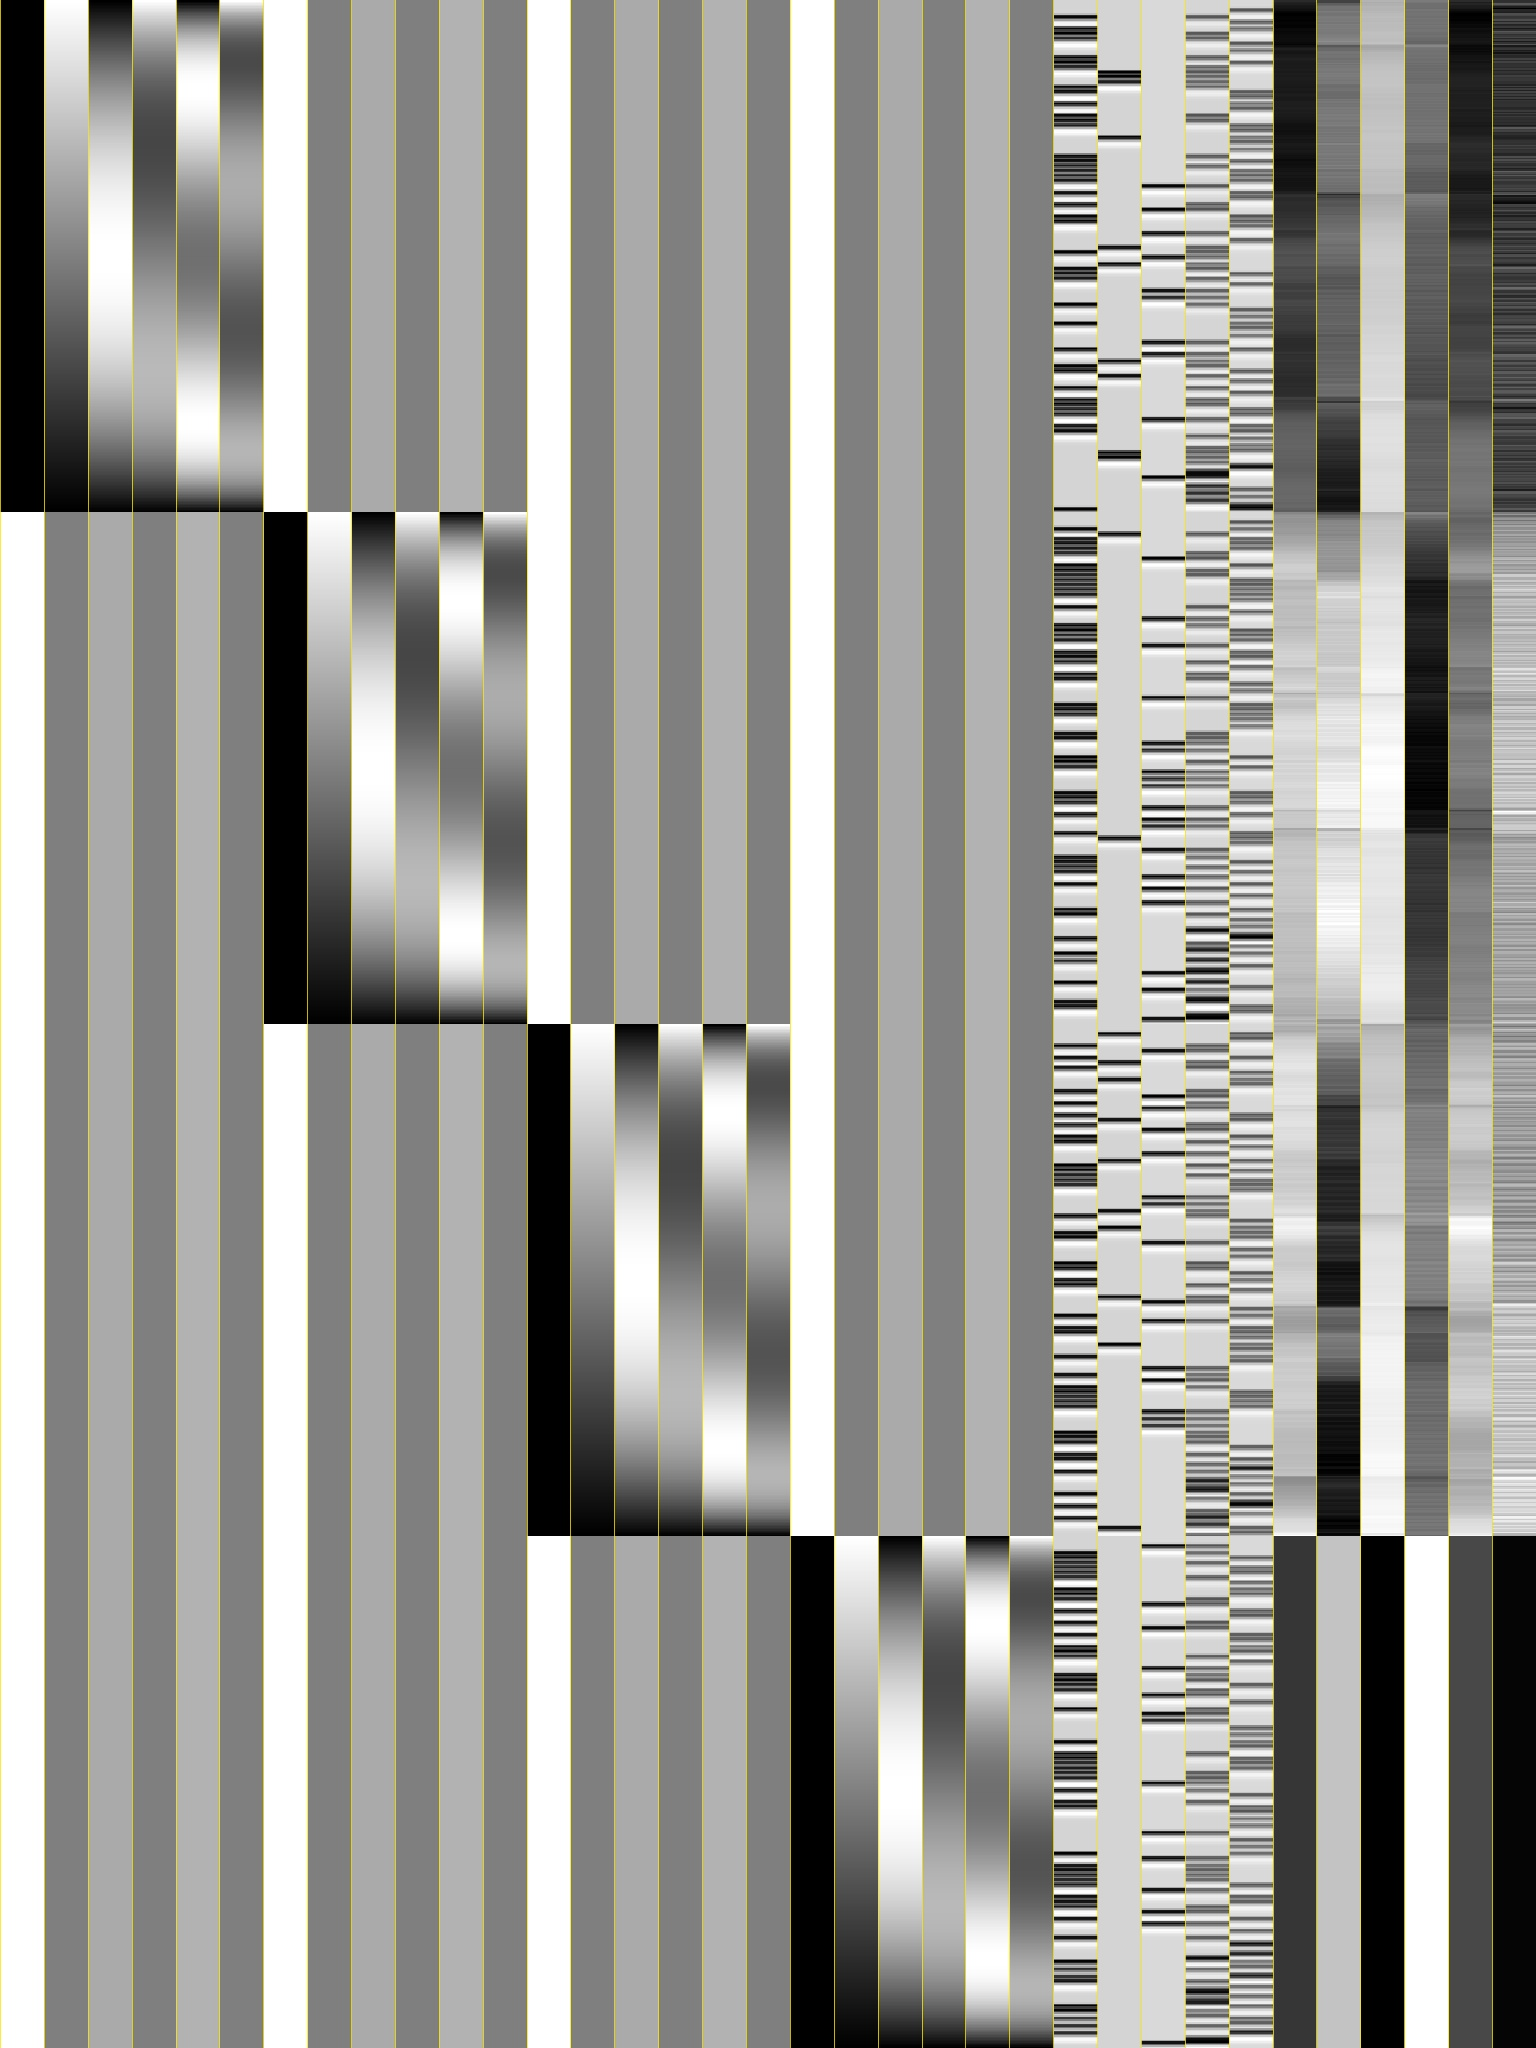

In [8]:
im_task = Image.open(os.path.join(os.getcwd(), 'X.task.jpg'))
im_task

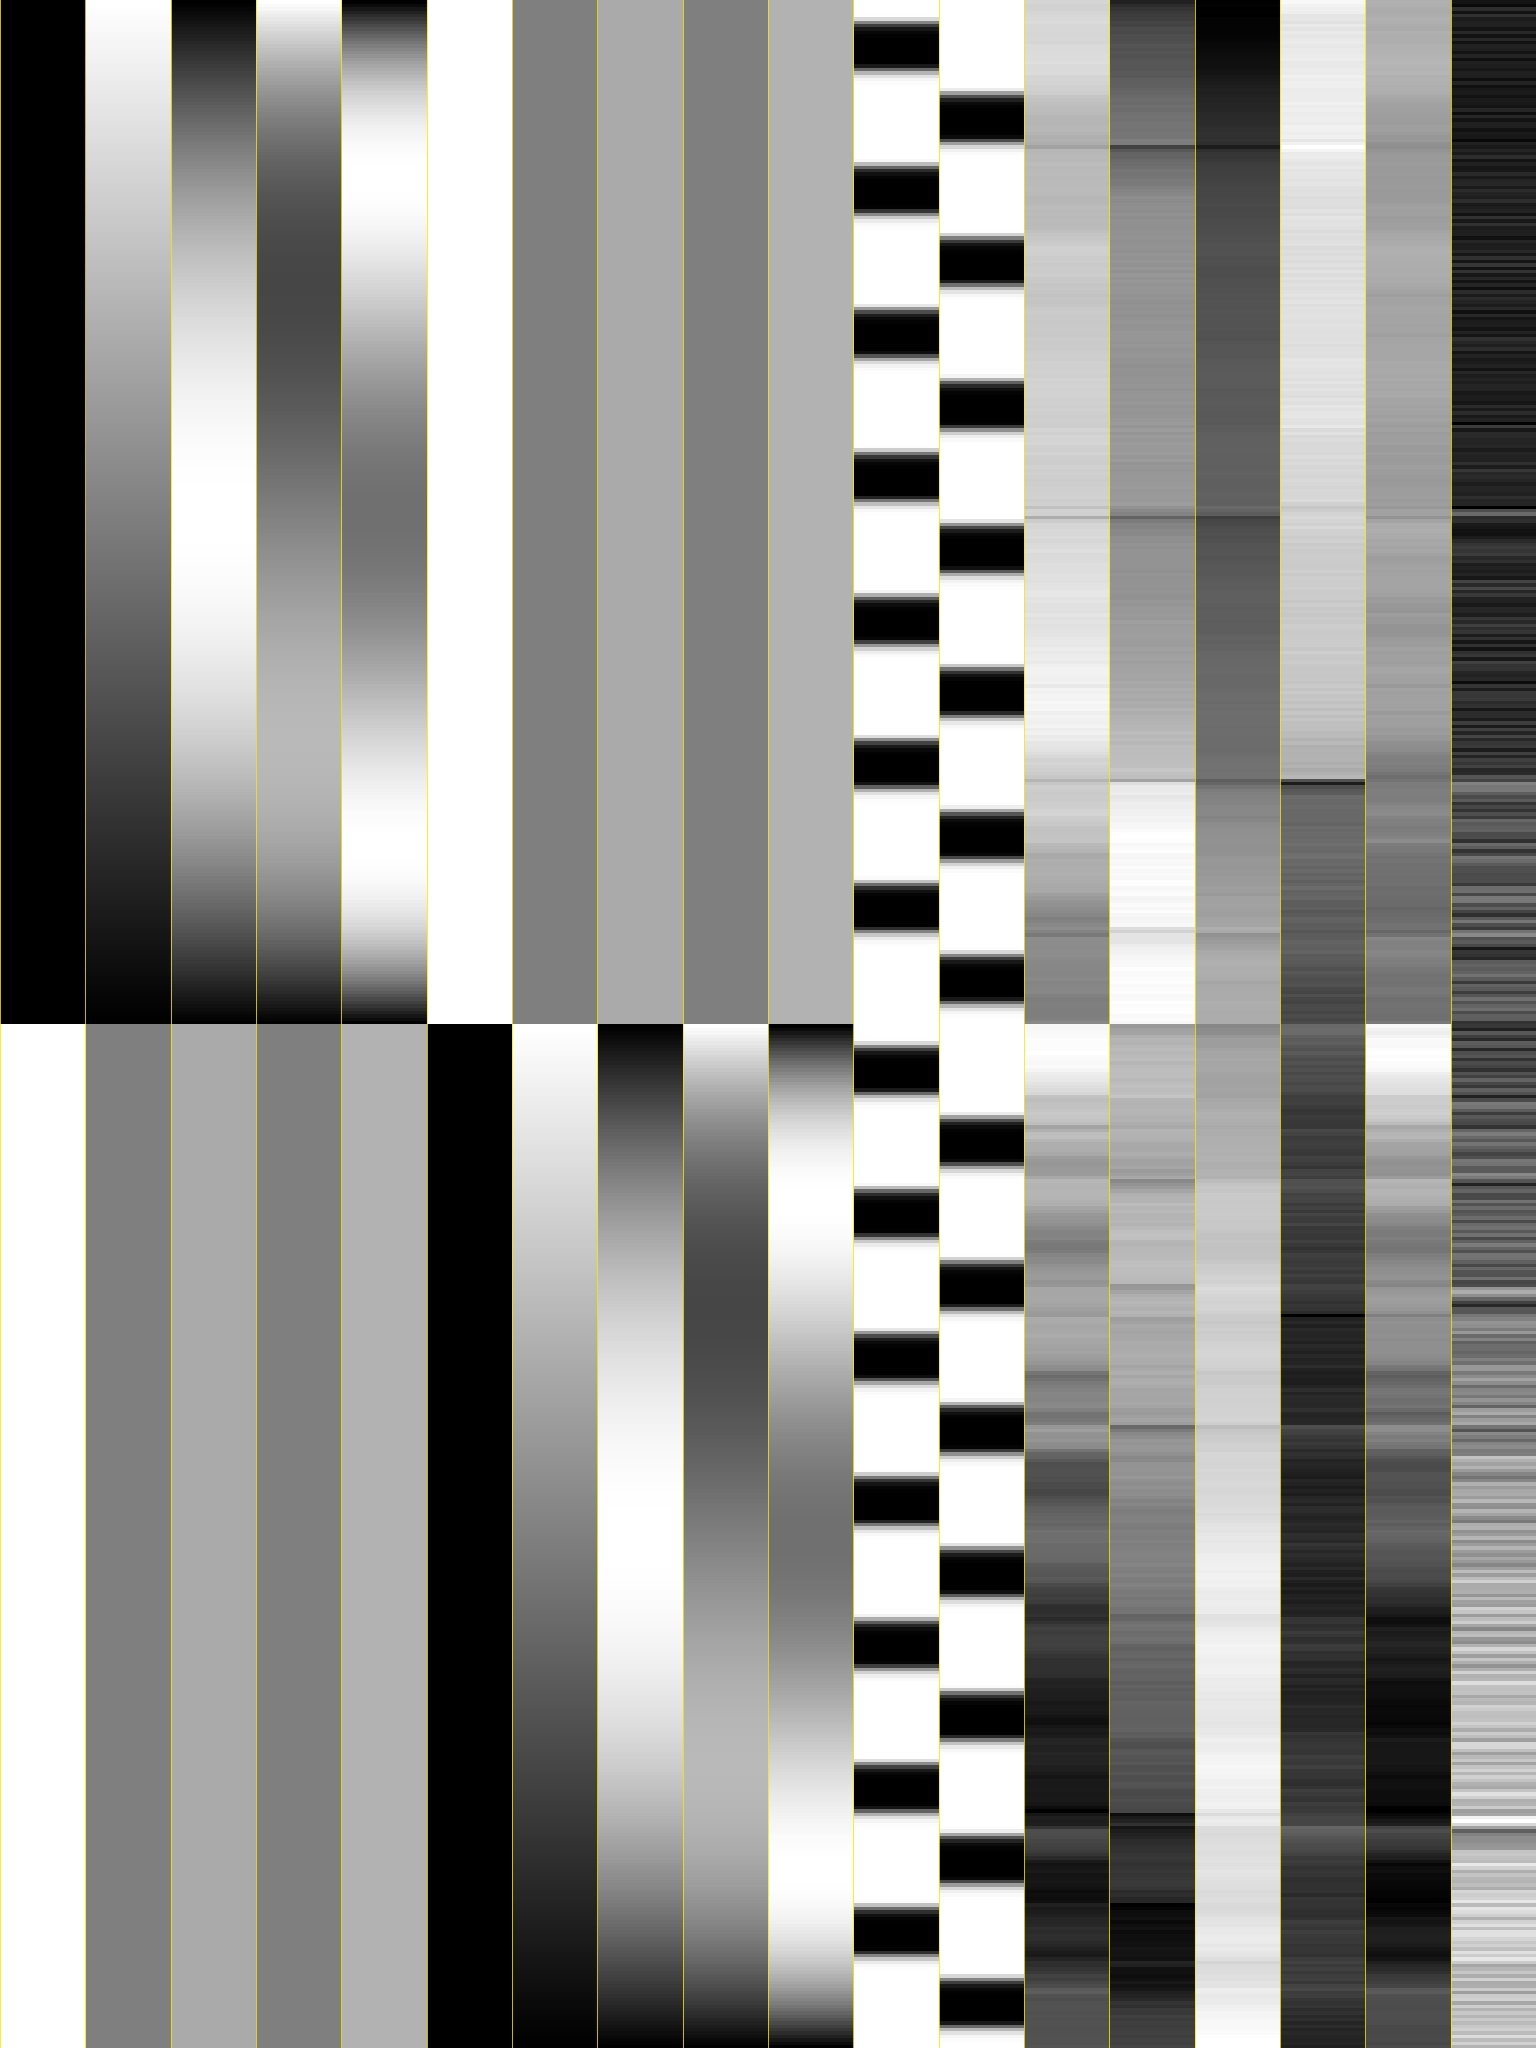

In [9]:
im_loc = Image.open(os.path.join(os.getcwd(), 'X.loc.jpg'))
im_loc